In [370]:
#instantiate cursor and load libraries
import json
import pandas as pd
import requests
import mysql.connector
import config
import time


In [371]:
#specify database for connection
db = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.password,
    database = "Movies")

cursor = db.cursor()

In [3]:
#create database
from mysql.connector import errorcode
db_name = 'Movies'

def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

In [4]:
import requests
from bs4 import BeautifulSoup as BS

In [5]:
#first page

page1 = requests.get('https://www.imdb.com/search/title/?release_date=2019-01-01,2019-10-31&sort=boxoffice_gross_us,desc&start=251&ref_=adv_nxt')
soup1 = BS(page1.content, 'html.parser')
soup1.prettify()
info1 = soup1.find_all(id = 'main')
movie1 = info1[0].find_all(class_='lister-item mode-advanced')

In [6]:
# insert_movies(make_df(movie1))

In [5]:
def get_score(movie):
        metascores = []
        for score in movie:
            metascore1 = score.find(class_="metascore")
            if metascore1 == None:
                metascore = 'Null'
                metascores.append(metascore)
            else:
                metascores.append(int(metascore1.get_text(strip=True)))
        return metascores
# len(get_score(movie))

In [6]:
def find_fk(movie):
    ids = []
    for m in movie:
        id = m.find (class_="starBarWidget")['id']
        ids.append(id)
    return ids

# find_fk(movie1)

In [7]:
def get_titles(movie):

    titles = []
    for one in movie:
        title = one.find('img')['alt']
        titles.append(title) 
    return titles

# len(get_titles(movie))

In [8]:
def get_stars(movie):
    stars = []
    for one in movie:
        try:
            stars.append(float(one.find(class_='inline-block ratings-imdb-rating')['data-value']))
        except:
            stars.append('Null')
#         stars.append(float(x['data-value']))
    return stars

# len(get_stars(movie))

In [9]:
def get_year(movie):
    
    years = []
    for one in movie:
        try:
            year = one.find(class_="lister-item-year text-muted unbold").get_text()
            parsed_year = year[-5:-1]
            years.append(int(parsed_year))
        except:
            years.append(2019)
    return years
# get_year(movie1)

In [10]:
def get_genre(movie):
    genres = []
    for m in movie:
        genre = m.find(class_='genre')
        try:
            genre1 = str.split(genre.get_text(strip=True), sep = ',')[0]
        except:
            genre1 = genre
        genres.append(genre1)
    return genres
# len(get_genre(movie1))

In [11]:
def get_gross(movie):
    gross_list = []
    
    for m in movie:
        gross = m.find(class_='sort-num_votes-visible')
        parsed_gross = gross.get_text(strip=True)
        parsed_gross2 = str.split(parsed_gross, sep='|')
       # print(parsed_gross2[1])
        if 'Gross' in parsed_gross2[0]:
            parsed_gross2 = parsed_gross2[0]
#             print(parsed_gross2[0])
            parsed_gross3 = str.split(parsed_gross2, sep=':')
#             print(parsed_gross3)
            parsed_gross4 = str.split(parsed_gross3[1], sep='.')[0]
            final_gross = str.split(parsed_gross4, sep='$')[1]
            gross_list.append(int(final_gross))
#             print(parsed_gross2)
        else:
            try:       
                parsed_gross3 = str.split(parsed_gross2[1], sep=':')
                parsed_gross4 = str.split(parsed_gross3[1], sep='.')[0]
                final_gross = str.split(parsed_gross4, sep='$')[1]
                gross_list.append(int(final_gross))
            except: 
                gross_list.append(0)
    
    return gross_list

# len(get_gross(movie))

In [41]:
#create table
DB_NAME = 'Movies'

create_query = """
      CREATE TABLE imdb_movies
    (
      imdb_id varchar(24),
      title varchar(50),
      year INT(4),
      star_rating FLOAT(3),
      metascore INT(5),
      gross INT(5),
      genre varchar(30),
      CONSTRAINT primary_key PRIMARY KEY(imdb_id)
      )
    """



In [12]:
#make into DF
def make_df(movie):
    all_movies_dataframe = pd.DataFrame({
        "imdb_id": find_fk(movie),
        "title": get_titles(movie),
        "year": get_year(movie),
        "star_rating": get_stars(movie),
        "metascore": get_score(movie),
        "gross": get_gross(movie),
        "genre": get_genre(movie)
    })
    return all_movies_dataframe


In [ ]:
#uses DF to insert into mySQL
def insert_movies(dataframe):
    all_movies_tuples = list(dataframe.itertuples(index=False, name=None))
    insert_statement = """INSERT INTO imdb_movies (imdb_id, title, year, star_rating, metascore, gross, genre) 
            VALUES (%s, %s, %s, %s, %s, %s, %s);"""
    for movie in all_movies_tuples:
        
        cursor.execute(insert_statement, movie)
        print(movie)
    
#     cursor.executemany(insert_statement, all_movies_tuples)
    db.commit()


In [ ]:
var = 251
while var < 750: 
    page = requests.get(f"https://www.imdb.com/search/title/?release_date=2019-01-01,2019-10-31&sort=boxoffice_gross_us,desc&start={var}&ref_=adv_nxt")
    soup = BS(page.content, 'html.parser')
    soup.prettify()
    info = soup.find_all(id = 'main')
    movie = info[0].find_all(class_='lister-item mode-advanced')
    movie_df = make_df(movie)
    insert_movies(movie_df)
    # #     print(movie_df)
    var +=50


In [51]:
cursor = db.cursor()

df = cursor.execute("""SELECT imdb_id FROM Movies.imdb_movies2;""")

df = pd.DataFrame(cursor.fetchall())

df.columns = [x[0] for x in cursor.description]

list_of_ids = df.values.tolist()

list_of_imdb_ids = [val[0] for val in list_of_ids]

# list_of_imdb_ids

In [5]:
api_key = '0bf0d1d80e2ab08ed768c022e7f27155'
all_info = []
for id_ in list_of_imdb_ids:
    find_external_id = requests.get(f'https://api.themoviedb.org/3/find/{id_}?api_key=0bf0d1d80e2ab08ed768c022e7f27155&language=en-US&external_source=imdb_id').json()
    find_external_id['imdb_id']=id_
    all_info.append(find_external_id)
    print(all_info[:5])

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}]
[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: B

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

[{'movie_results': [{'id': 399579, 'video': False, 'vote_count': 3685, 'vote_average': 6.9, 'title': 'Alita: Battle Angel', 'release_date': '2019-01-31', 'original_language': 'en', 'original_title': 'Alita: Battle Angel', 'genre_ids': [28, 12, 878, 53], 'backdrop_path': '/8yjqnpOfuFQg3qLRl9Ca1NgIBB5.jpg', 'adult': False, 'overview': 'When Alita awakens with no memory of who she is in a future world she does not recognize, she is taken in by Ido, a compassionate doctor who realizes that somewhere in this abandoned cyborg shell is the heart and soul of a young woman with an extraordinary past.', 'poster_path': '/xRWht48C2V8XNfzvPehyClOvDni.jpg', 'popularity': 34.006}], 'person_results': [], 'tv_results': [], 'tv_episode_results': [], 'tv_season_results': [], 'imdb_id': 'tt0437086'}, {'movie_results': [{'id': 287947, 'video': False, 'vote_count': 3636, 'vote_average': 7.0, 'title': 'Shazam!', 'release_date': '2019-03-23', 'original_language': 'en', 'original_title': 'Shazam!', 'genre_ids'

In [ ]:
DB_NAME = 'Movies'
create_query = """
      CREATE TABLE md_movies
    (
      imdb_id varchar(24),
      title varchar(50),
      release_date INT(4),
      overview varchar(50),
      FOREIGN KEY (imdb_id) REFERENCES imdb_movies2(imdb_id),
      ID INT AUTO_INCREMENT PRIMARY KEY
      )
    """
# cursor.execute(create_query)

In [ ]:
def get_release_date(all_info):
    release_dates = []
    for movie in all_info:
        try:
            info = movie['movie_results'][0]
            release_date = info['release_date']
            release_dates.append(release_date)
        except:
            release_date = 'Null'
            release_dates.append(release_date)
    return release_dates

In [ ]:
def get_overview(all_info):
    overviews = []
    for movie in all_info:
        try:
            info = movie['movie_results'][0]
            overview = info['overview']
            overviews.append(overview)
        except:
            overview = 'Null'
            overviews.append(overview)
    return overviews
# get_overview(all_info)

In [ ]:
def get_title(all_info):
    titles = []
    for movie in all_info:
        try:
            info = movie['movie_results'][0]
            title = info['original_title']
            titles.append(title)
        except:
            title = 'Null'
            titles.append(title)
    return titles
# get_title(all_info)

In [71]:
def make_df(all_info):
    mymoviedatabase_df = pd.DataFrame({
        "imdb_id": list_of_imdb_ids,
        "title": get_title(all_info),
        "release_date": get_release_date(all_info),
        "overview": get_overview(all_info),
        })
    return mymoviedatabase_df

make_df(all_info).head()

,imdb_id,title,release_date,overview
0,tt0437086,Alita: Battle Angel,2019-01-31,When Alita awakens with no memory of who she i...
1,tt0448115,Shazam!,2019-03-23,A boy is given the ability to become an adult ...
2,tt0837563,Pet Sematary,2019-04-04,"Dr. Louis Creed and his wife, Rachel, move fro..."
3,tt0859635,Super Troopers 2,2018-04-19,When an international border dispute arises be...
4,tt10003978,Fiddler: A Miracle of Miracles,2019-07-18,The origin story behind one of Broadway's most...


In [ ]:
def insert_movies(dataframe):
    all_movies_tuples = list(dataframe.itertuples(index=False, name=None))
    insert_statement = """INSERT INTO Movies.md_movies (imdb_id_, title, release_date, overview) 
            VALUES (%s, %s, %s, %s);"""
    for movie in all_movies_tuples:
        
        cursor.execute(insert_statement, movie)
        print(movie)
    
#     cursor.executemany(insert_statement, all_movies_tuples)
    db.commit()

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

In [447]:
#query all star_ratings from database
cursor = db.cursor()

moviedf = cursor.execute("""SELECT * FROM Movies.join_table ORDER BY gross DESC;""")

moviedf = pd.DataFrame(cursor.fetchall())

moviedf.columns = [x[0] for x in cursor.description]

moviedf.drop(moviedf[moviedf.index>300].index, inplace=True)
moviedf.drop(moviedf[moviedf.metascore==0].index, inplace=True)

In [448]:
moviedf['genre'].value_counts()

Action         79
Comedy         51
Drama          44
Biography      31
Animation      25
Adventure      19
Horror         17
Crime           9
Documentary     3
Fantasy         1
Name: genre, dtype: int64

In [449]:
moviedf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.087223,-0.018776,0.048940
star_rating,0.087223,1.000000,0.688850,0.320473
metascore,-0.018776,0.688850,1.000000,0.226547
gross,0.048940,0.320473,0.226547,1.000000


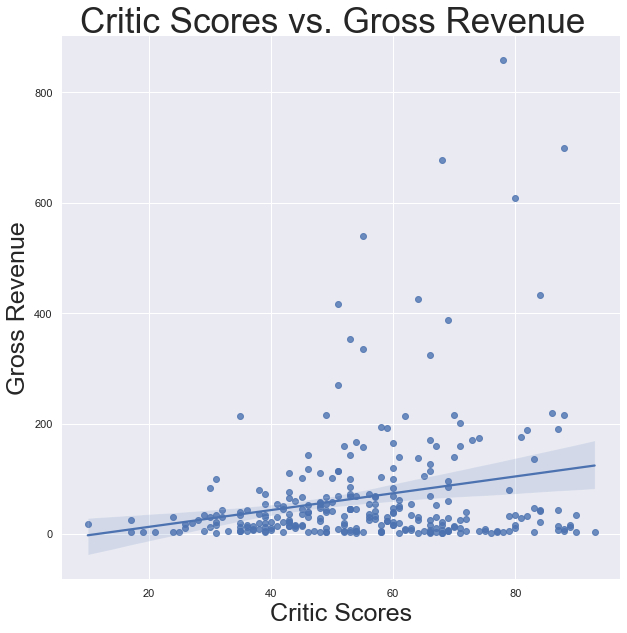

In [471]:
f, ax = plt.subplots(figsize=(10, 10))
sns.despine (f, left=True, bottom =True)

fig = sns.regplot(x=moviedf['metascore'], y=moviedf['gross'], data=moviedf, truncate=True)
fig.figure.suptitle('Critic Scores vs. Gross Revenue', y=0.92,fontsize = 35)
fig.set(xlabel='Critic Scores', ylabel='Gross Revenue')
plt.rcParams["axes.labelsize"] = 25

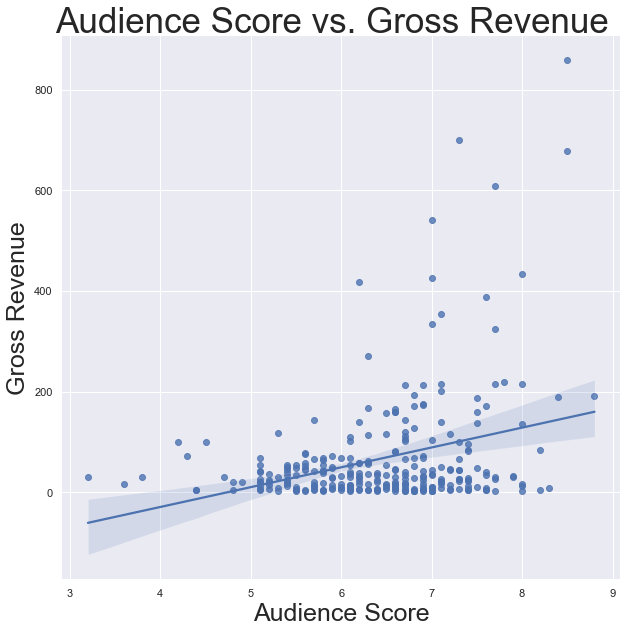

In [470]:
f, ax = plt.subplots(figsize=(10, 10))
sns.despine (f, left=True, bottom =True)

fig = sns.regplot(x=moviedf['star_rating'], y=moviedf['gross'], data=moviedf, truncate=True)
fig.figure.suptitle('Audience Score vs. Gross Revenue', y=0.92,fontsize = 35)
fig.set(xlabel='Audience Score', ylabel='Gross Revenue')
plt.rcParams["axes.labelsize"] = 25

In [198]:
# sns.lineplot(x=moviedf['release_date', y="signal",
#              hue="region", style="event")

In [454]:
dramadf = moviedf.drop(moviedf[moviedf.genre != 'Drama'].index)

In [455]:
dramadf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.057010,-0.018534,0.102035
star_rating,0.057010,1.000000,0.703100,0.236511
metascore,-0.018534,0.703100,1.000000,0.272745
gross,0.102035,0.236511,0.272745,1.000000


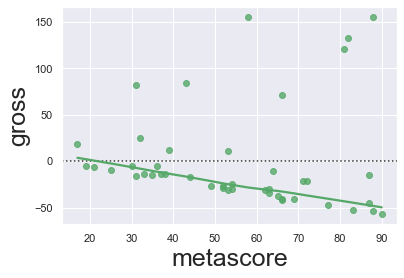

In [456]:
sns.residplot(x=dramadf['metascore'], y=dramadf['gross'], lowess=True, color="g")

In [457]:
actiondf = moviedf.drop(moviedf[moviedf.genre != 'Action'].index)

In [458]:
actiondf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.136812,0.019405,0.069728
star_rating,0.136812,1.000000,0.677370,0.615359
metascore,0.019405,0.677370,1.000000,0.557501
gross,0.069728,0.615359,0.557501,1.000000


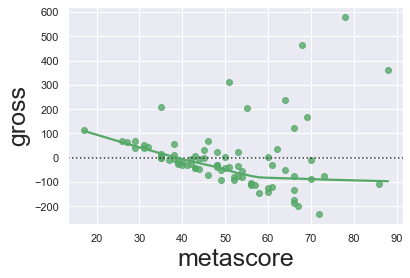

In [459]:
sns.residplot(x=actiondf['metascore'], y=actiondf['gross'], lowess=True, color="g")

In [460]:
animationdf = moviedf.drop(moviedf[moviedf.genre != 'Animation'].index)

In [461]:
animationdf.corr()

,year,star_rating,metascore,gross
year,1.000000,-0.120656,-0.187472,-0.019112
star_rating,-0.120656,1.000000,0.815481,0.350652
metascore,-0.187472,0.815481,1.000000,0.350106
gross,-0.019112,0.350652,0.350106,1.000000


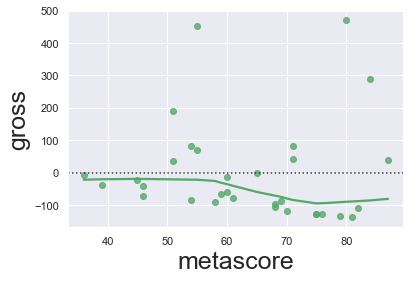

In [410]:
sns.residplot(x=animationdf['metascore'], y=animationdf['gross'], lowess=True, color="g")

In [465]:
adventuredf = moviedf.drop(moviedf[moviedf.genre != 'Adventure'].index)

In [466]:
adventuredf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.330005,0.067240,0.165460
star_rating,0.330005,1.000000,0.624266,0.135122
metascore,0.067240,0.624266,1.000000,-0.115592
gross,0.165460,0.135122,-0.115592,1.000000


In [467]:
biographydf = moviedf.drop(moviedf[moviedf.genre != 'Biography'].index)

In [468]:
biographydf.corr()

,year,star_rating,metascore,gross
year,1.000000,-0.016149,-0.262982,0.016707
star_rating,-0.016149,1.000000,0.621742,0.486196
metascore,-0.262982,0.621742,1.000000,-0.055066
gross,0.016707,0.486196,-0.055066,1.000000


In [462]:
horrordf = moviedf.drop(moviedf[moviedf.genre != 'Horror'].index)

In [463]:
horrordf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.400838,0.327233,-0.111512
star_rating,0.400838,1.000000,0.691101,0.288625
metascore,0.327233,0.691101,1.000000,0.571684
gross,-0.111512,0.288625,0.571684,1.000000


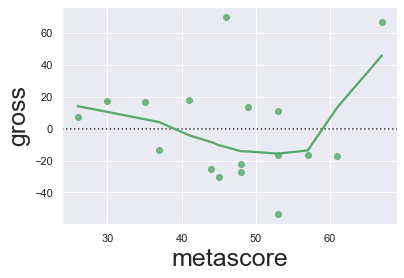

In [464]:
sns.residplot(x=horrordf['metascore'], y=horrordf['gross'], lowess=True, color="g")

[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Documentary'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Horror')]

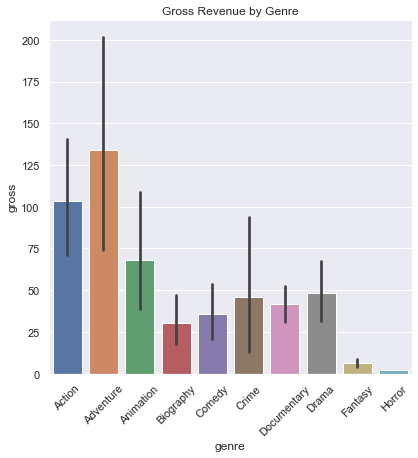

In [426]:
sns.set(style="darkgrid")

#create plot of total Gross Revenue by Genre
sf, ax = plt.subplots(figsize=(6.5, 6.5))

bygenre = sns.barplot(x=moviedf['genre'], y=moviedf['gross'])
bygenre.set_title('Gross Revenue by Genre')
bygenre.set_xticklabels(gross_plotted.get_xticklabels(),rotation=45)

In [427]:
#create dataframe of the average gross revenue grouped by genre
gross_mean = pd.DataFrame(moviedf.groupby('genre')['gross'].mean()).reset_index()

Text(0.5, 1.0, 'Average Gross Revenue by Genre')

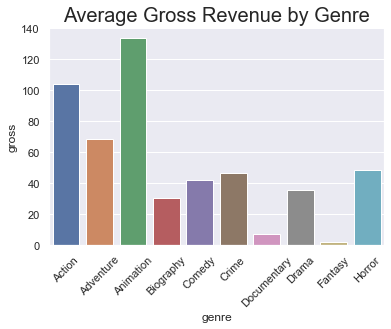

In [428]:
gross_plotted = sns.barplot(x=gross_mean['genre'], y=gross_mean['gross'])
gross_plotted.set_xticklabels(gross_plotted.get_xticklabels(),rotation=45)
gross_plotted.set_title('Average Gross Revenue by Genre', fontsize=20)

In [429]:
#create dataframe of the median gross revenue grouped by genre
gross_median = pd.DataFrame(moviedf.groupby('genre')['gross'].median()).reset_index()

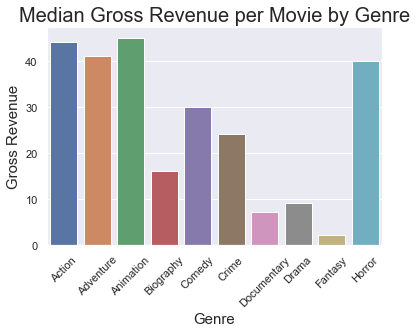

In [434]:
gross_plotted = sns.barplot(x=gross_median['genre'], y=gross_median['gross'])
gross_plotted.set_xticklabels(gross_plotted.get_xticklabels(),rotation=45)
gross_plotted.set_title('Median Gross Revenue per Movie by Genre', fontsize=20)
gross_plotted.set(xlabel='Genre', ylabel='Gross Revenue')
plt.rcParams["axes.labelsize"] = 20

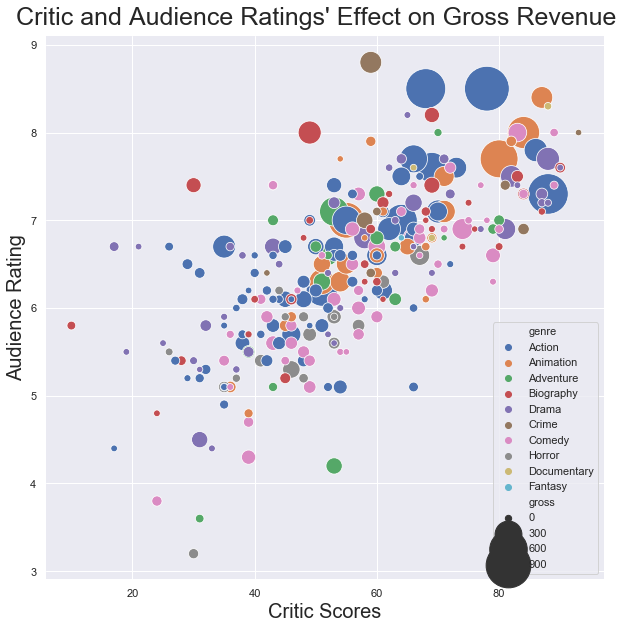

In [473]:
f, ax = plt.subplots(figsize=(10, 10))
sns.despine (f, left=True, bottom =True)

fig = sns.scatterplot(x=moviedf['metascore'], y=moviedf['star_rating'], size = moviedf['gross'],sizes = (40,2000), hue = moviedf['genre'])
fig.figure.suptitle("Critic and Audience Ratings' Effect on Gross Revenue", y=0.92, fontsize = 25)
fig.set(xlabel='Critic Scores', ylabel='Audience Rating')
plt.rcParams["axes.labelsize"] = 20